In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Embedding
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Data pre-processing
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from scipy import stats
from numpy import savetxt

import seaborn as sns

C:\Users\ali.zaheer\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data set

In [2]:
imdb_df = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt',delimiter='\t',
                        header=None, 
                        names=['review', 'sentiment'])

### Data Prep, EDA and Data Cleaning

In [3]:
imdb_df.columns.to_list()

['review', 'sentiment']

In [4]:
imdb_df.shape

(748, 2)

In [5]:
imdb_df.head(10)

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [7]:
imdb_df.sentiment.head()

0    0
1    0
2    0
3    0
4    1
Name: sentiment, dtype: int64

In [8]:
# Data type in the series
print ('Sentiment Data Type: {}'.format(imdb_df.sentiment.dtypes))
print ('Sentiment Data Type: {}'.format(imdb_df.review.dtype))
#imdb_df.review = imdb_df.review.astype(str)
#print(imdb_df.dropna(inplace=True))

Sentiment Data Type: int64
Sentiment Data Type: object


In [9]:
# count of zero and positives values
imdb_df.sentiment.value_counts()

1    386
0    362
Name: sentiment, dtype: int64

C:\Users\ali.zaheer\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


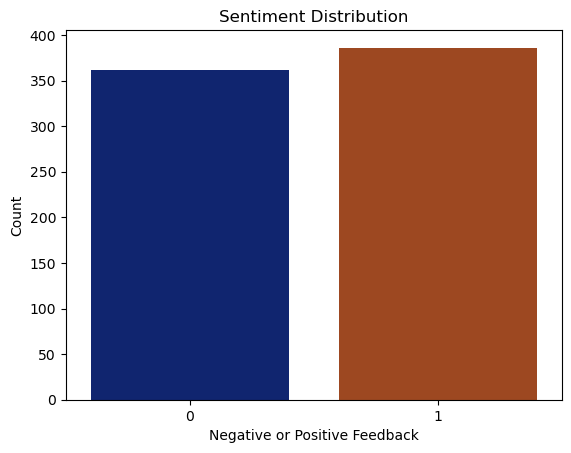

In [10]:
# visualize sentiments
sns.countplot(imdb_df.sentiment, x=imdb_df.sentiment, palette='dark')
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Negative or Positive Feedback')
plt.show()

In [11]:
# Check if there are any null values
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

<AxesSubplot:>

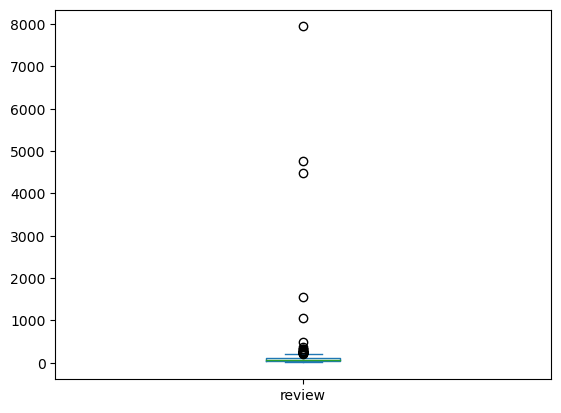

In [12]:
# Idenitfy outliers in the review length
imdb_df.review.str.len().plot.box()

### Remove outlier from the dataset

In [13]:
outliers = imdb_df.review.str.len().quantile(0.99)
q_low = imdb_df.review.str.len().quantile(0.01)
q_hi  = imdb_df.review.str.len().quantile(0.99)

imdb_df = imdb_df[(imdb_df.review.str.len() < q_hi) & (imdb_df.review.str.len() > q_low)]

<AxesSubplot:>

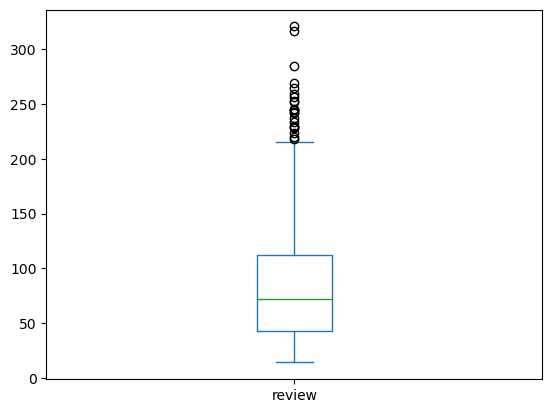

In [14]:
# Idenitfy outliers in the review length
imdb_df.review.str.len().plot.box()

<AxesSubplot:title={'center':'Review length Histogram'}, ylabel='Frequency'>

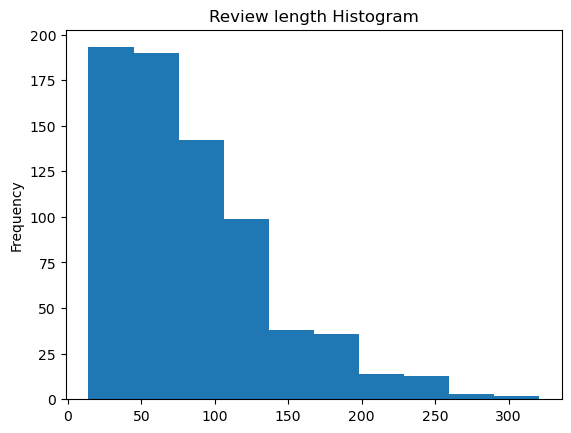

In [15]:
# Investigate distribution of Revenue column using histogram
imdb_df.review.str.len().plot(kind = "hist", title = 'Review length Histogram')

In [16]:
# Identify all special characters
import re
list_of_special_chars =  'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmonpqrstuvwxyz'
identified_list = []
for comms in imdb_df.review:
    for char in comms:
        if char not in list_of_special_chars:
            identified_list.append(char)
identified_list = pd.Series(identified_list).drop_duplicates().reset_index()

In [17]:
identified_list.head()

,index,0
0,0,
1,1,","
2,6,-
3,17,.
4,47,&


In [18]:
# remove special characters and numbers from the reviews
import re
def remove_special_char(data):
    pat = r'[^a-zA-Z]' # regex to identify special characters
    return (re.sub(pat, ' ', data))
    
#remove_special_char('“007 Not sure@% #fun! 558923 do# ** of it.? $500USD!”')

In [19]:
# Remove Special characters
imdb_df.review = imdb_df.review.apply(remove_special_char)

In [20]:
# Convert data to lowercase
imdb_df['review'] = imdb_df.review.apply(lambda x: " ".join(x.lower() for x in x.split()))

In [54]:
imdb_df['review']

0      a very very very slow moving aimless movie abo...
1      not sure who was more lost the flat characters...
2      attempting artiness with black white and cleve...
3              very little music or anything to speak of
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately any virtue in this film s produc...
745                         in a word it is embarrassing
746                                    exceptionally bad
747    all in all its an insult to one s intelligence...
Name: review, Length: 730, dtype: object

In [22]:
print('Min lenght of review: ',imdb_df.review.str.len().min())
print('Median lenght of review: ',imdb_df.review.str.len().median())
print('Max lenght of review: ',imdb_df.review.str.len().max())

Min lenght of review:  11
Median lenght of review:  69.0
Max lenght of review:  313


In [23]:
# Extract sentence and labels
sentence = np.array(imdb_df['review'])
rating = np.array(imdb_df['sentiment'])

In [24]:
type(rating)

numpy.ndarray

In [25]:
# find max lenght of the list in the encoded_docs
def FindMaxLength(lst):
    maxList = max((x) for x in lst)
    maxLength = max(len(x) for x in lst )
    minLength = min(len(x) for x in lst )
    #return maxList, maxLength
    return maxLength, minLength
     
# Driver Code
#print('Max lenght: {}, Min length: {}'.format(FindMaxLength(X_train)[0],FindMaxLength(X_train)[1]))

In [26]:
# visualize accuracy and loss of the first model
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [27]:
# Identify stopwords
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ali.zaheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stopwords = set(stopwords.words('english'))

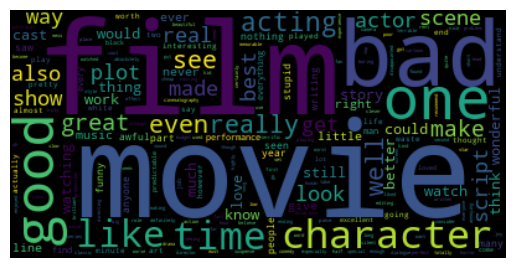

In [29]:
stopwords.update(["br", "href"])

textt = " ".join(review for review in sentence)

wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

### Split into training and testing sets.

In [30]:
# split the data 80/20
X_train, X_test, Y_train, Y_test = train_test_split(sentence, rating, test_size=0.2, random_state = 1000, stratify=rating)

In [31]:
# train and test dataset
print('Train dataset: ', X_train.shape)
print('test dataset: ', X_test.shape)
print('Train dataset: ', Y_train.shape)
print('test dataset: ', Y_test.shape)

Train dataset:  (584,)
test dataset:  (146,)
Train dataset:  (584,)
test dataset:  (146,)


In [32]:
#Apply the tokenizer and pad to a max length
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_s = tokenizer.texts_to_sequences(X_train)
X_test_s = tokenizer.texts_to_sequences(X_test)

In [33]:
#Idenitfy vocabolary
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', len(tokenizer.word_index)+1)

Vocabulary Size:  2160


In [34]:
#Sample of the Vocabulary data
list(tokenizer.word_index.items())[50:60]

[('has', 51),
 ('really', 52),
 ('characters', 53),
 ('my', 54),
 ('were', 55),
 ('great', 56),
 ('more', 57),
 ('see', 58),
 ('her', 59),
 ('also', 60)]

In [35]:
# Max sequence length
print('Max length: {}, Min length: {}'.format(FindMaxLength(X_train_s)[0],FindMaxLength(X_train_s)[1]))

Max length: 57, Min length: 2


### Padding the sentence

In [36]:
X_train = pad_sequences(X_train_s, maxlen=FindMaxLength(X_train_s)[0])
X_test = pad_sequences(X_test_s, maxlen=FindMaxLength(X_test_s)[0])

In [37]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  20  11 810   6   2 155   7  16  33
 811   3 470]


In [38]:
### Save the training and test data

savetxt('padded_X_train.csv', X_train)
savetxt('padded_X_test.csv', X_test)
savetxt('rating_Y_train.csv', Y_train)
savetxt('rating_Y_test.csv', Y_test)

In [39]:
# find out max embedding
max_embd = int(round(np.sqrt(vocab_size),0))
print(max_embd)

46


In [40]:
# early stopping monitor
esm = EarlyStopping(patience=2)

model = Sequential() 
model.add(Embedding(vocab_size, output_dim=max_embd, input_length=FindMaxLength(X_train_s)[0]) )
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 57, 46)            99360     
                                                                 
 lstm (LSTM)                 (None, 50)                19400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 118,811
Trainable params: 118,811
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(X_train, Y_train,
                    validation_split=0.2,
                    epochs=10,
                    callbacks=esm,
                    batch_size=32) # slicing the data into "batches" of size batch_size, 
                                   # and repeatedly iterating over the entire dataset for a given number of epochs

Epoch 1/10
15/15 [==============================] - 4s 83ms/step - loss: 0.6918 - accuracy: 0.5375 - val_loss: 0.6907 - val_accuracy: 0.5812
Epoch 2/10
15/15 [==============================] - 1s 62ms/step - loss: 0.6842 - accuracy: 0.6617 - val_loss: 0.6865 - val_accuracy: 0.5897
Epoch 3/10
15/15 [==============================] - 1s 84ms/step - loss: 0.6669 - accuracy: 0.6916 - val_loss: 0.6747 - val_accuracy: 0.6154
Epoch 4/10
15/15 [==============================] - 1s 80ms/step - loss: 0.6044 - accuracy: 0.7666 - val_loss: 0.6693 - val_accuracy: 0.6068
Epoch 5/10
15/15 [==============================] - 1s 78ms/step - loss: 0.4821 - accuracy: 0.8094 - val_loss: 0.6469 - val_accuracy: 0.6239
Epoch 6/10
15/15 [==============================] - 1s 80ms/step - loss: 0.3556 - accuracy: 0.8951 - val_loss: 0.6601 - val_accuracy: 0.6752
Epoch 7/10
15/15 [==============================] - 1s 82ms/step - loss: 0.2760 - accuracy: 0.9208 - val_loss: 0.6728 - val_accuracy: 0.6410


In [43]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f} Testing Loss {:.4f}".format(accuracy,loss))

Testing Accuracy:  0.7466 Testing Loss 0.5513


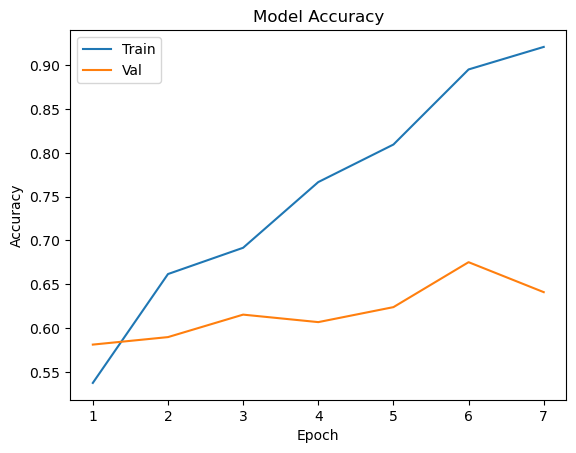

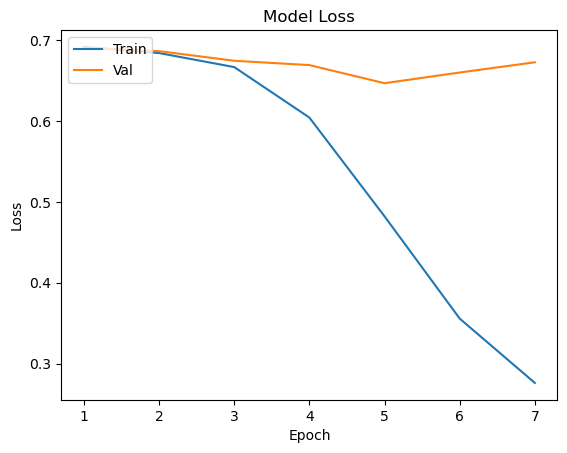

In [44]:
plot_learningCurve(history,len(history.epoch))

In [45]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=FindMaxLength(X_train_s)[0])
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", prediction)

### Test the model by adding sentances

In [46]:
print('Actual Data :{}, Rating {}'.format(imdb_df.review.head()[1],imdb_df.sentiment.head()[1]))

Actual Data :not sure who was more lost the flat characters or the audience nearly half of whom walked out, Rating 0


In [47]:
imdb_df.head(10)

,review,sentiment
0,a very very very slow moving aimless movie abo...,0
1,not sure who was more lost the flat characters...,0
2,attempting artiness with black white and cleve...,0
3,very little music or anything to speak of,0
4,the best scene in the movie was when gerardo i...,1
5,the rest of the movie lacks art charm meaning ...,0
6,wasted two hours,0
7,saw the movie today and thought it was a good ...,1
8,a bit predictable,0
9,loved the casting of jimmy buffet as the scien...,1


In [53]:
imdb_df['review'][0]

'a very very very slow moving aimless movie about a distressed drifting young man'

In [63]:
test_sentence2 = 'a very very very slow moving aimless movie about a distressed drifting young man'
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 25ms/step
Predicted label:  0


In [64]:
imdb_df['review'][4]

'the best scene in the movie was when gerardo is trying to find a song that keeps running through his head'

In [65]:
test_sentence2 = "saw the movie today and thought it was a good ..."
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 57ms/step
Predicted label:  1


### Saving the model

In [50]:
model.save('D213Task2.keras')